## **Zhuang Lab Astrocyte Analysis**
James Fu<br>
Spring 2024<br>
C&S BIO 199

In [6]:
from scipy import stats
from scipy.stats import ttest_ind
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import anndata
import pandas as pd
from sklearn.neighbors import NearestNeighbors

In [7]:
download_base = 'metadata'

# df_1 to df_4 represents each mouse sample
folder_1 = os.path.join(download_base, '1')
file_path_1 = os.path.join(folder_1, 'cell_metadata_with_cluster_annotation.csv')
if os.path.exists(file_path_1):
    df_1 = pd.read_csv(file_path_1, index_col=0)
folder_2 = os.path.join(download_base, '2')
file_path_2 = os.path.join(folder_2, 'cell_metadata_with_cluster_annotation.csv')
if os.path.exists(file_path_2):
    df_2 = pd.read_csv(file_path_2, index_col=0)
folder_3 = os.path.join(download_base, '3')
file_path_3 = os.path.join(folder_3, 'cell_metadata_with_cluster_annotation.csv')
if os.path.exists(file_path_3):
    df_3 = pd.read_csv(file_path_3, index_col=0)
folder_4 = os.path.join(download_base, '4')
file_path_4 = os.path.join(folder_4, 'cell_metadata_with_cluster_annotation.csv')
if os.path.exists(file_path_4):
    df_4 = pd.read_csv(file_path_4, index_col=0)

In [8]:
pd.set_option('display.max_columns', None)
df_1.head(5)

,brain_section_label,feature_matrix_label,donor_label,donor_genotype,donor_sex,cluster_alias,x,y,z,subclass_confidence_score,cluster_confidence_score,high_quality_transfer,neurotransmitter,class,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color
cell_label,,,,,,,,,,,,,,,,,,,,,,
182941331246012878296807398333956011710,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,704,0.682522,3.366483,7.82953,0.969933,0.718088,True,GABA,06 CTX-CGE GABA,049 Lamp5 Gaba,0199 Lamp5 Gaba_1,0709 Lamp5 Gaba_1,#FF3358,#CCFF33,#FF764D,#DC00FF,#998900
221260934538535633595532020856387724686,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,5243,0.667690,3.442241,7.82953,0.850554,0.850554,True,NaN,33 Vascular,331 Peri NN,1191 Peri NN_1,5304 Peri NN_1,#666666,#858881,#82992E,#2F00CC,#BB1FCC
22228792606814781533240955623030943708,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,14939,0.638731,3.474328,7.82953,0.888285,0.649581,True,NaN,30 Astro-Epen,319 Astro-TE NN,1163 Astro-TE NN_3,5225 Astro-TE NN_3,#666666,#594a26,#3DCCB1,#a8afa5,#551799
272043042552227961220474294517855477150,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,14939,0.653425,3.433218,7.82953,0.900000,0.607080,True,NaN,30 Astro-Epen,319 Astro-TE NN,1163 Astro-TE NN_3,5225 Astro-TE NN_3,#666666,#594a26,#3DCCB1,#a8afa5,#551799
110116287883089187971185374239350249328,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,5254,0.623896,3.513574,7.82953,0.999978,0.689511,True,NaN,33 Vascular,333 Endo NN,1193 Endo NN_1,5310 Endo NN_1,#666666,#858881,#994567,#00992A,#FFB473


In [9]:
# create a function to only include astrocytes in our 4 sample dfs to reduce the amount of code
def filter_astro(df):
    astro_df = df[df['class'].str.contains('30 Astro-Epen', case=False, na=False)]
    return astro_df

In [10]:
astro_df_1 = filter_astro(df_1)
astro_df_2 = filter_astro(df_2)
astro_df_3 = filter_astro(df_3)
astro_df_4 = filter_astro(df_4)

In [11]:
combined_astro_df = pd.concat([astro_df_1, astro_df_2, astro_df_3, astro_df_4])
# find the unique subclasses across all 4 samples
astro_subclasses = combined_astro_df['subclass'].unique()
# across our samples, there are 10 unique astro subclasses of interest
print(astro_subclasses)
print(len(astro_subclasses))

['319 Astro-TE NN' '320 Astro-OLF NN' '325 CHOR NN' '323 Ependymal NN'
 '318 Astro-NT NN' '321 Astroependymal NN' '322 Tanycyte NN'
 '324 Hypendymal NN' '317 Astro-CB NN' '316 Bergmann NN']
10


From our above observations, all astrocyte subtypes are in the first 3 samples, and 9 out of 10 of the astrocyte subtypes are in the last sample.

In [12]:
# specific unique subclasses
astro_subclasses_1 = astro_df_1['subclass'].unique()
astro_subclasses_2 = astro_df_2['subclass'].unique()
astro_subclasses_3 = astro_df_3['subclass'].unique()
astro_subclasses_4 = astro_df_4['subclass'].unique()
print(len(astro_subclasses_1))
print(len(astro_subclasses_2))
print(len(astro_subclasses_3))
print(len(astro_subclasses_4))

10
10
10
9


### **The below code is to visually look at how the different subtypes of astrocytes tile the brain using MERFISH**

In [13]:
import pandas as pd

# Define a list to store DataFrames
merfish_dfs = []

# Loop through each directory and read the CSV file into a DataFrame
for i in range(1, 5):
    filename = f"metadata/{i}/cell_metadata_with_cluster_annotation.csv"
    df = pd.read_csv(filename)
    merfish_dfs.append(df)

merfish_df_1, merfish_df_2, merfish_df_3, merfish_df_4 = merfish_dfs

In [14]:
merfish_df_1.head()

,cell_label,brain_section_label,feature_matrix_label,donor_label,donor_genotype,donor_sex,cluster_alias,x,y,z,subclass_confidence_score,cluster_confidence_score,high_quality_transfer,neurotransmitter,class,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color
0,182941331246012878296807398333956011710,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,704,0.682522,3.366483,7.82953,0.969933,0.718088,True,GABA,06 CTX-CGE GABA,049 Lamp5 Gaba,0199 Lamp5 Gaba_1,0709 Lamp5 Gaba_1,#FF3358,#CCFF33,#FF764D,#DC00FF,#998900
1,221260934538535633595532020856387724686,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,5243,0.667690,3.442241,7.82953,0.850554,0.850554,True,NaN,33 Vascular,331 Peri NN,1191 Peri NN_1,5304 Peri NN_1,#666666,#858881,#82992E,#2F00CC,#BB1FCC
2,22228792606814781533240955623030943708,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,14939,0.638731,3.474328,7.82953,0.888285,0.649581,True,NaN,30 Astro-Epen,319 Astro-TE NN,1163 Astro-TE NN_3,5225 Astro-TE NN_3,#666666,#594a26,#3DCCB1,#a8afa5,#551799
3,272043042552227961220474294517855477150,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,14939,0.653425,3.433218,7.82953,0.900000,0.607080,True,NaN,30 Astro-Epen,319 Astro-TE NN,1163 Astro-TE NN_3,5225 Astro-TE NN_3,#666666,#594a26,#3DCCB1,#a8afa5,#551799
4,110116287883089187971185374239350249328,Zhuang-ABCA-1.089,Zhuang-ABCA-1,Zhuang-ABCA-1,wt/wt,F,5254,0.623896,3.513574,7.82953,0.999978,0.689511,True,NaN,33 Vascular,333 Endo NN,1193 Endo NN_1,5310 Endo NN_1,#666666,#858881,#994567,#00992A,#FFB473


### **From a quick glance, it seems as if each of the four MERFISH samples has a different number of brain sections.**
Our findings are summarized in the table below
| Sample | Brain Sections |
|--------|----------------|
|   1    |      147       |
|   2    |       66       |
|   3    |       23       |
|   4    |        3       |


In [15]:
unique_sections = []
for df in merfish_dfs:
    unq_sections = df['brain_section_label'].unique()
    unique_sections.append(unq_sections)

# Print the unique sections for each DataFrame
for i, sections in enumerate(unique_sections, start=1):
    print(f"Unique sections for merfish_df_{i}:")
    print("Brain section " + str(i) + " has " + str(len(sections)) + " sections")
    print(sections)
    print()

Unique sections for merfish_df_1:
Brain section 1 has 147 sections
['Zhuang-ABCA-1.089' 'Zhuang-ABCA-1.077' 'Zhuang-ABCA-1.087'
 'Zhuang-ABCA-1.072' 'Zhuang-ABCA-1.082' 'Zhuang-ABCA-1.084'
 'Zhuang-ABCA-1.051' 'Zhuang-ABCA-1.061' 'Zhuang-ABCA-1.048'
 'Zhuang-ABCA-1.058' 'Zhuang-ABCA-1.068' 'Zhuang-ABCA-1.043'
 'Zhuang-ABCA-1.053' 'Zhuang-ABCA-1.063' 'Zhuang-ABCA-1.045'
 'Zhuang-ABCA-1.055' 'Zhuang-ABCA-1.065' 'Zhuang-ABCA-1.097'
 'Zhuang-ABCA-1.107' 'Zhuang-ABCA-1.117' 'Zhuang-ABCA-1.091'
 'Zhuang-ABCA-1.111' 'Zhuang-ABCA-1.103' 'Zhuang-ABCA-1.113'
 'Zhuang-ABCA-1.125' 'Zhuang-ABCA-1.133' 'Zhuang-ABCA-1.141'
 'Zhuang-ABCA-1.095' 'Zhuang-ABCA-1.105' 'Zhuang-ABCA-1.115'
 'Zhuang-ABCA-1.099' 'Zhuang-ABCA-1.109' 'Zhuang-ABCA-1.119'
 'Zhuang-ABCA-1.121' 'Zhuang-ABCA-1.129' 'Zhuang-ABCA-1.137'
 'Zhuang-ABCA-1.123' 'Zhuang-ABCA-1.131' 'Zhuang-ABCA-1.139'
 'Zhuang-ABCA-1.127' 'Zhuang-ABCA-1.135' 'Zhuang-ABCA-1.143'
 'Zhuang-ABCA-1.145' 'Zhuang-ABCA-1.147' 'Zhuang-ABCA-1.149'
 'Zhuang-ABCA-1.00

### **For the first sample, here is the distribution of astrocytes for each sample.**
The provided function takes in four arguments as input (the size of astro subclass cells, sample, unique brain section, astrocyte subtype) so we can look at the distribution of that subtype vs. other astrocytes vs. non astrocyte cells.<br>
Lastly, the size argument is to deal with cases where the cells are too sparse, we can still see them compared to other cells.

In [16]:
def plot_cell_distribution(size, merfish_sample, brain_section_label, astro_subtype):
    df = merfish_sample[merfish_sample['brain_section_label'] == brain_section_label]
    df_astro_n_subtype = df[(df['class'] == '30 Astro-Epen') & (df['brain_section_label'] == brain_section_label) & (df['subclass'] != astro_subtype)]
    df_astro_subtype = df[(df['class'] == '30 Astro-Epen') & (df['brain_section_label'] == brain_section_label) & (df['subclass'] == astro_subtype)]

    plt.figure(figsize=(8, 6))
    plt.scatter(df['x'], -df['y'], s=1, edgecolor='none', label='All cells', color='gray')
    plt.scatter(df_astro_n_subtype['x'], -df_astro_n_subtype['y'], s=3, edgecolor='none', label='All astrocyte excluding subclass', color='green')
    plt.scatter(df_astro_subtype['x'], -df_astro_subtype['y'], s=size, edgecolor='none', label=f'Astro subtype {astro_subtype}', color='blue')

    # Highlight the specified astro subtype
    df_specified_subtype = df[(df['class'] == astro_subtype) & (df['brain_section_label'] == brain_section_label)]

    plt.xlabel('x pos')
    plt.ylabel('y pos')
    plt.title(f'Cell Distribution for Brain Section {brain_section_label}')
    plt.legend()
    plt.show()

Several test cases of plot function for MERFISH data...

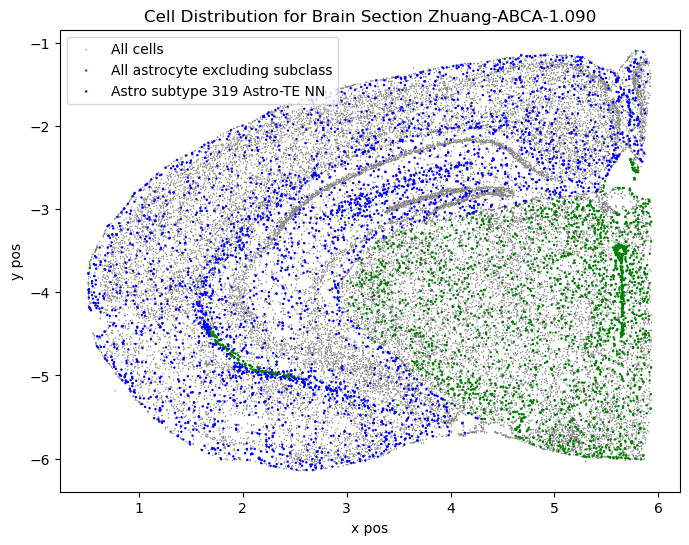

In [17]:
plot_cell_distribution(3, merfish_df_1, 'Zhuang-ABCA-1.090', '319 Astro-TE NN')

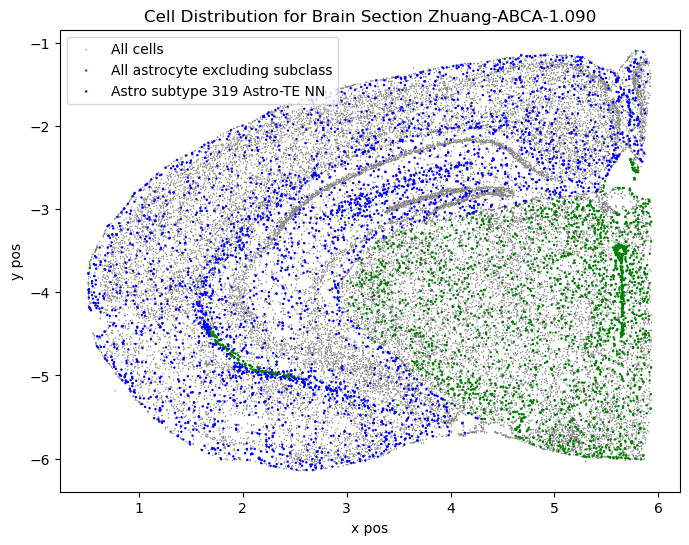

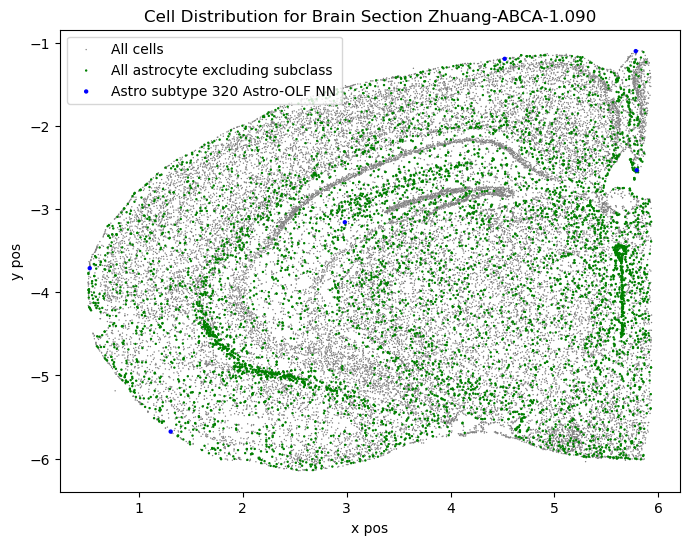

In [18]:
# a few more test cases
# example where most astrocytes are of subclass 319 Astro-TE NN, so we should use small size of '3' on plot
plot_cell_distribution(3, merfish_df_1, 'Zhuang-ABCA-1.090', '319 Astro-TE NN')
# example where most astrocytes are of another subclass, so we should use large size of '10' on plot
plot_cell_distribution(10, merfish_df_1, 'Zhuang-ABCA-1.090', '320 Astro-OLF NN')

In [19]:
# Assuming your dataframe is named df

# Filter rows where class is "30 Astro-Epen"
df_filtered = df[df['class'] == '30 Astro-Epen']

# Selecting relevant columns
features = df_filtered[['x', 'y', 'z', 'supertype', 'neurotransmitter', 'cluster_alias']]

# Handling NaN values if any
features.fillna(value='Unknown', inplace=True)

# Encode categorical features
features_encoded = pd.get_dummies(features)

# Initialize KNN model
knn_model = NearestNeighbors(n_neighbors=5)  # You can adjust the number of neighbors as needed

# Fit the model
knn_model.fit(features_encoded)

# Example query point (you can replace this with your own query)
query_point = [[x_query, y_query, z_query, 0, 1, 0, 0, 0, 1, 0, 0, 0]]  # Assuming 'Unknown' for categorical features

# Query the model
distances, indices = knn_model.kneighbors(query_point)

# Print the indices of nearest neighbors
print("Indices of nearest neighbors:", indices)

/var/folders/h7/2y_y3n0n7qqfsj983dbyx_380000gn/T/ipykernel_3347/3117098377.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(value='Unknown', inplace=True)


NameError: name 'x_query' is not defined